# L0,L1 smoothness and Frank-Wolfe on log regression

### Целевая функция

Будем оптимизировать задачу бинарной классификации
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \text{log}(1 + \text{exp}(-y_i (Ax)_i))
$$
, где $x \in \mathbb{R}^d$, $L= \text{max}_i \| A_i \|^2$, $L_0 = 0$, $L_1 = \text{max}_i \| A_i \|$ $(\| A_i \| >> 1)$

### Данные 
Эксперименты проводились на следующих данных:
- $a_i$ – случайный вектор из $\mathbb{R}^d$, взятый из нормального распределения
- Датасет a9a Platt (1998), доступный из библиотеки LIBSVM

Начальная точка x0 = [0, 0, 0, ...] + \epsilon

### Алгоритмы
В экспериментах сравниваются следующие методы:
- Алгоритм Франк-Вульфа с шагом основанным на L0,L1 гладкости (FW-L0_L1)
- Алгоритм Франк-Вульфа классический (FW-stand) с shortest step
- (Пока убрал, т.к. пока смысла не увидел в нем тут) Алгоритм Франк-Вульфа c убывающим шагом  (FW-desc)

### Цель эксперимента

Ответим на вопросы
1) Будет ли FW-L0_L1 быстрее, чем FW-stand? 
2) Посмотреть на разных диаметрах множества, т.к. ожидаю, что алгоритм $L_0,L_1$ будет быстрее на мелких диаметрах
3) Как повлияет начальное значение параметров $L_0,L_1$ на скорость сходимости алгоритма? Что, если один из параметров будет сильно ниже, чем второй параметр? В обычной $L$ гладкости такой возможности нет.
4) Опционально. Было бы интересно посмотреть сколько раз выполняется каждый из видов шага, часто ли будет переключаться на логарифмический шаг?

In [1]:
import sys
import os

# Get the parent directory of the notebook (2 levels up)
notebook_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))
if notebook_dir not in sys.path:
    sys.path.append(notebook_dir)

In [2]:
from matplotlib.ticker import ScalarFormatter
import numpy as np
import matplotlib.pyplot as plt

import accbpg
from accbpg.utils import random_point_on_simplex

## Лог функция, адаптивные параметры

### Меняем размерность и число векторов

radius is  250
true omega radius is  238.47060668497755
ratio positive labels: 0.49

FW L0,L1 smooth algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    4.620e+00    4.545e-10    4.195e+00        1         0.1
   200    1.199e-05    3.228e-05    4.545e-10    4.195e+00      201         0.2
   400    1.869e-08    4.618e-08    4.545e-10    4.195e+00      401         0.3

FW adaptive algorithm
     k      F(x)         Lk       time
     0   6.931e-01   4.259e+01     0.0
   200   2.597e-05   4.061e-05     0.1
   400   5.697e-08   3.173e-07     0.2
   600   4.072e-10   2.479e-09     0.2

FW L0,L1 smooth algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    4.620e+00    4.545e-10    4.195e+00        1         0.0
   200    4.904e-03    9.044e-03    4.545e-10    4.195e+00      201         0.1
   400    4.459e-04    9.034e-04    4.545e-10    4.195e+00      401         0.1
   600

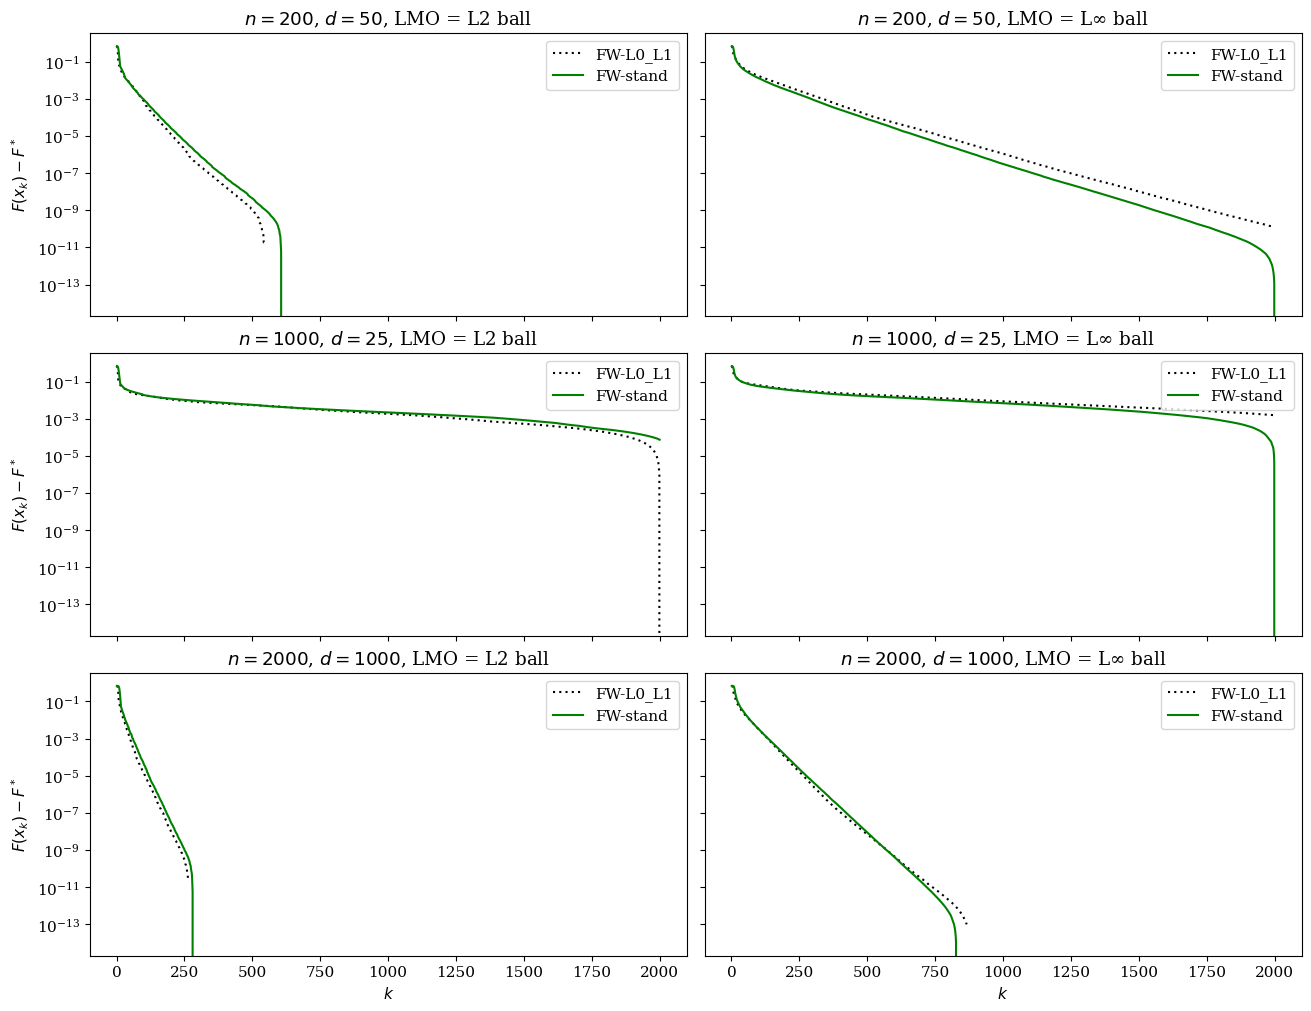

In [4]:
plt.rcParams.update({'font.size': 11, 'font.family': 'serif'})

fig, axes = plt.subplots(3, 2, figsize=(13, 10), sharex=True, sharey=True, constrained_layout=True)

eps = 1e-14
max_iters = 2000
verbskip = max_iters / 10
ls_ratio = 2.2

l1_max_factor = 5

ball_constrnt_radius = 250
# n_samples, n_features = 1000, 25

solution_spread_radius_btm = 0.95
solution_spread_radius_up = 0.99

labels = [r"FW-L0_L1", r"FW-stand"]

configs = [
    (200, 50),
    (1000, 25),
    (2000, 1000),
]

lmo_names = ["L2 ball", "L∞ ball"]

for i, (n_samples, n_features) in enumerate(configs):
    np.random.seed(2025 + i)
    f, h, L, L0, L1, x0 = accbpg.L0L1_FW_log_reg(n_samples, n_features, ball_constrnt_radius, 
                                                 solution_spread_radius_btm=solution_spread_radius_btm, 
                                                 solution_spread_radius_up=solution_spread_radius_up)

    for j, (lmo, lmo_name) in enumerate(zip(
        [accbpg.lmo_l2_ball(ball_constrnt_radius), accbpg.lmo_linf_ball(ball_constrnt_radius)], lmo_names
    )):
        _, F_l0l1, _, _, _ = accbpg.FW_alg_l0_l1_step_adapt(
            f, h, L0, L1, x0, max_iters, lmo, ls_ratio, L1_max=L1 * l1_max_factor,
            epsilon=eps, linesearch=True, verbskip=verbskip
        )

        _, F_standard, _, _ = accbpg.FW_alg_div_step(
            f, h, L, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo,
            epsilon=eps, linesearch=True, verbskip=verbskip
        )

        ax = axes[i, j]
        accbpg.plot_comparisons(
            ax,
            [F_l0l1, F_standard],
            labels,
            x_vals=[], plotdiff=True, yscale="log",
            xlabel=r"$k$" if i == 2 else "",
            ylabel=r"$F(x_k) - F^*$" if j == 0 else "",
            legendloc="upper right"
        )

        ax.set_title(f"$n = {n_samples}$, $d = {n_features}$, LMO = {lmo_name}")

# Optional: save the figure
# plt.savefig("FW_comparison_grid.pdf", bbox_inches='tight')
plt.show()

### Меняем радиус допустимого множества

radius is  1.0
true omega radius is  0.98137356373096
ratio positive labels: 0.498

FW L0,L1 smooth algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    2.833e+00    4.545e-10    3.157e+00        1         0.2

FW adaptive algorithm
     k      F(x)         Lk       time
     0   6.931e-01   2.412e+01     0.0

FW L0,L1 smooth algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    2.833e+00    4.545e-10    3.157e+00        1         0.0
   200    2.323e-01    1.287e-01    2.066e-10    1.435e+00      201         0.1
   400    2.291e-01    1.263e-01    9.391e-11    6.523e-01      401         0.1
   600    2.281e-01    1.255e-01    9.391e-11    6.523e-01      601         0.2
   800    2.276e-01    1.250e-01    2.066e-10    1.435e+00      801         0.3
  1000    2.272e-01    1.248e-01    9.391e-11    6.523e-01     1001         0.4
  1200    2.270e-01    1.246e-01    9.391e-1

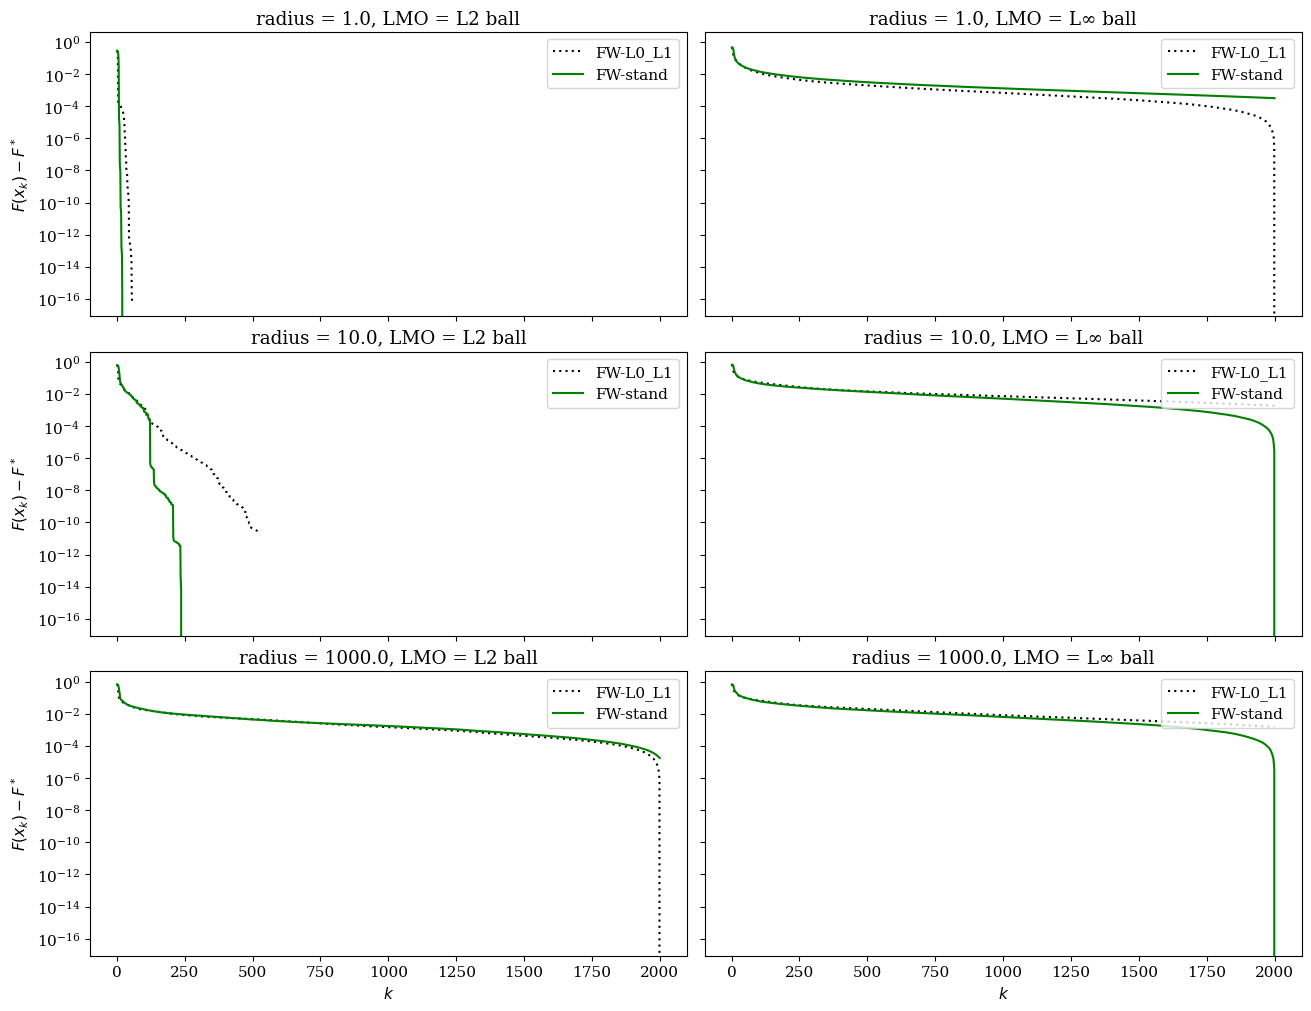

In [3]:
plt.rcParams.update({'font.size': 11, 'font.family': 'serif'})

fig, axes = plt.subplots(3, 2, figsize=(13, 10), sharex=True, sharey=True, constrained_layout=True)

eps = 1e-14
max_iters = 2000
verbskip = max_iters / 10
ls_ratio = 2.2

l1_max_factor = 5

# parameters which ill be variated
# ball_constrnt_radius = 250
n_samples, n_features = 1000, 25

solution_spread_radius_btm = 0.95
solution_spread_radius_up = 0.99

radii = [1.0, 10.0, 1000.0]  # log-scale variation of radius
labels = [r"FW-L0_L1", r"FW-stand"]
lmo_names = ["L2 ball", "L∞ ball"]

for i, ball_constrnt_radius in enumerate(radii):
    f, h, L, L0, L1, x0 = accbpg.L0L1_FW_log_reg(
        n_samples, n_features, ball_constrnt_radius,
        solution_spread_radius_btm=solution_spread_radius_btm,
        solution_spread_radius_up=solution_spread_radius_up
    )

    for j, (lmo, lmo_name) in enumerate(zip(
        [accbpg.lmo_l2_ball(ball_constrnt_radius), accbpg.lmo_linf_ball(ball_constrnt_radius)], lmo_names
    )):
        _, F_l0l1, _, _, _ = accbpg.FW_alg_l0_l1_step_adapt(
            f, h, L0, L1, x0, max_iters, lmo, ls_ratio, L1_max=L1 * l1_max_factor,
            epsilon=eps, linesearch=True, verbskip=verbskip
        )

        _, F_standard, _, _ = accbpg.FW_alg_div_step(
            f, h, L, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo,
            epsilon=eps, linesearch=True, verbskip=verbskip
        )

        ax = axes[i, j]
        accbpg.plot_comparisons(
            ax,
            [F_l0l1, F_standard],
            labels,
            x_vals=[], plotdiff=True, yscale="log",
            xlabel=r"$k$" if i == 2 else "",
            ylabel=r"$F(x_k) - F^*$" if j == 0 else "",
            legendloc="upper right"
        )

        ax.set_title(f"radius = {ball_constrnt_radius}, LMO = {lmo_name}")

# Optional: save the figure
# plt.savefig("FW_vs_radius_grid.pdf", bbox_inches='tight')
plt.show()


### Меняем удаленность решения от центра шара. От ближайшего к более дальнему.

radius is  250
true omega radius is  20.051242257540313
ratio positive labels: 0.505

FW L0,L1 smooth algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    2.911e+00    4.545e-10    3.347e+00        1         0.1
    60    3.905e-02    7.751e-03    2.066e-10    1.522e+00       61         0.1
   120    2.936e-02    2.192e-02    1.000e-09    7.364e+00      121         0.2
   180    2.282e-02    1.797e-02    1.000e-09    7.364e+00      181         0.2
   240    1.972e-02    1.154e-02    1.000e-09    7.364e+00      241         0.2
   300    1.805e-02    1.087e-02    1.000e-09    7.364e+00      301         0.3
   360    1.680e-02    1.016e-02    1.000e-09    7.364e+00      361         0.3
   420    1.565e-02    9.537e-03    1.000e-09    7.364e+00      421         0.3
   480    1.453e-02    2.324e-02    4.840e-09    3.564e+01      481         0.3
   540    1.328e-02    1.360e-02    2.200e-09    1.620e+01      541         0.4

FW adapt

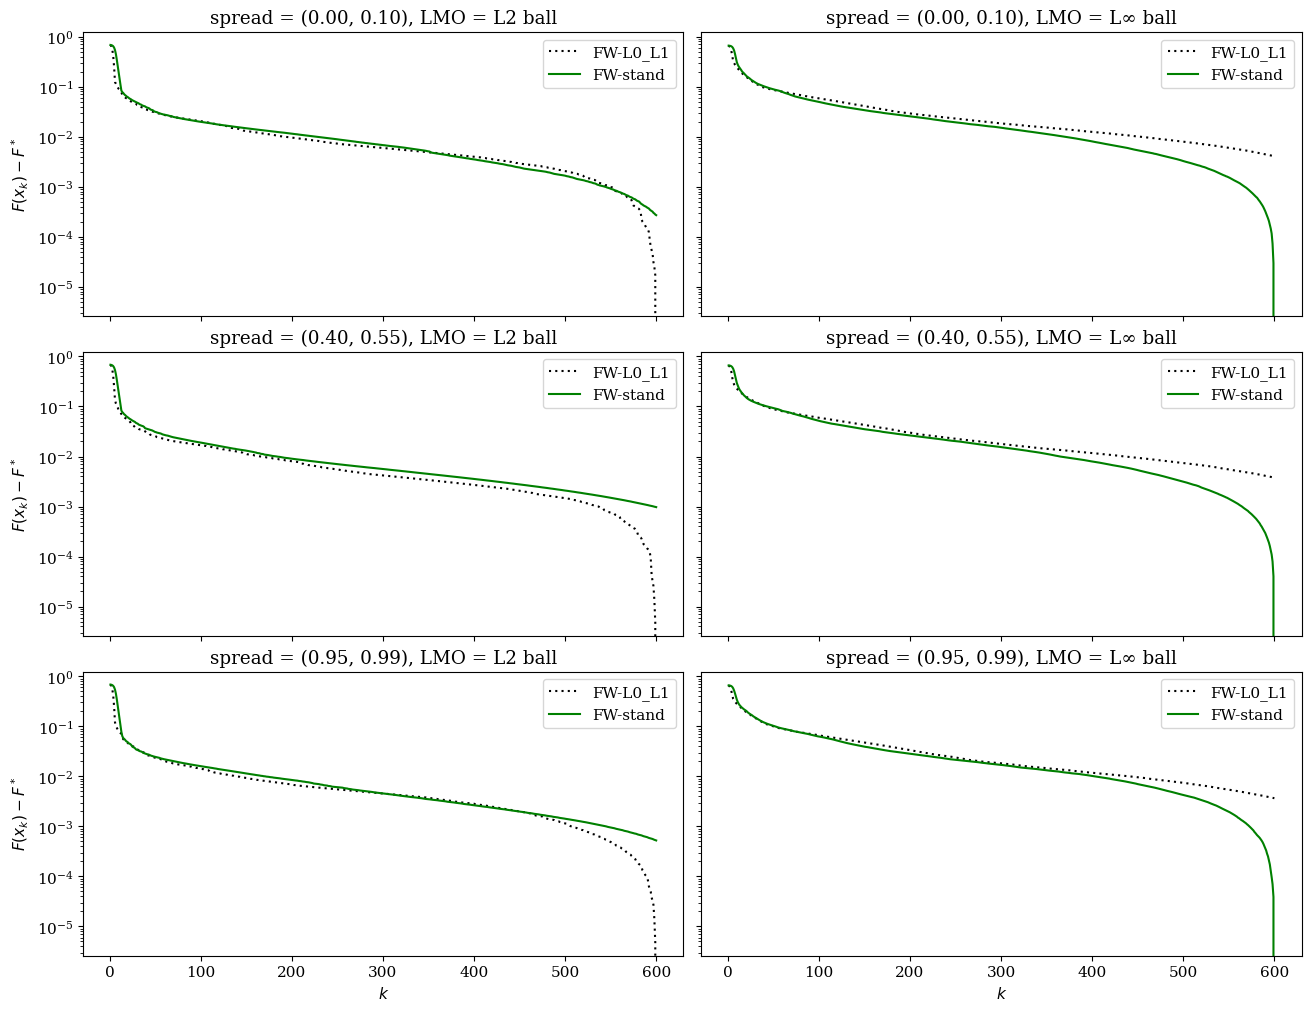

In [6]:
plt.rcParams.update({'font.size': 11, 'font.family': 'serif'})

fig, axes = plt.subplots(3, 2, figsize=(13, 10), sharex=True, sharey=True, constrained_layout=True)

eps = 1e-14
max_iters = 600
verbskip = max_iters / 10
ls_ratio = 2.2

l1_max_factor = 5

# parameters which ill be variated
ball_constrnt_radius = 250
n_samples, n_features = 1000, 25

# solution_spread_radius_btm = 0.95
# solution_spread_radius_up = 0.99

# Fixed parameters
labels = [r"FW-L0_L1", r"FW-stand"]
lmo_names = ["L2 ball", "L∞ ball"]

# The spread configurations (three rows)
spread_configs = [(0.0, 0.1), (0.4, 0.55), (0.95, 0.99)]

for i, (spread_btm, spread_up) in enumerate(spread_configs):
    np.random.seed(2025 + i)  # for reproducibility

    f, h, L, L0, L1, x0 = accbpg.L0L1_FW_log_reg(
        n_samples, n_features, ball_constrnt_radius,
        solution_spread_radius_btm=spread_btm,
        solution_spread_radius_up=spread_up
    )

    for j, (lmo, lmo_name) in enumerate(zip(
        [accbpg.lmo_l2_ball(ball_constrnt_radius), accbpg.lmo_linf_ball(ball_constrnt_radius)],
        lmo_names
    )):
        _, F_l0l1, _, _, _ = accbpg.FW_alg_l0_l1_step_adapt(
            f, h, L0, L1, x0, max_iters, lmo, ls_ratio, L1_max=L1 * l1_max_factor,
            epsilon=eps, linesearch=True, verbskip=verbskip
        )

        _, F_standard, _, _ = accbpg.FW_alg_div_step(
            f, h, L, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo,
            epsilon=eps, linesearch=True, verbskip=verbskip
        )

        ax = axes[i, j]
        accbpg.plot_comparisons(
            ax,
            [F_l0l1, F_standard],
            labels,
            x_vals=[], plotdiff=True, yscale="log",
            xlabel=r"$k$" if i == 2 else "",
            ylabel=r"$F(x_k) - F^*$" if j == 0 else "",
            legendloc="upper right"
        )

        ax.set_title(
            fr"spread = ({spread_btm:.2f}, {spread_up:.2f}), LMO = {lmo_name}"
        )

# Optional: save the figure
# plt.savefig("FW_spread_variation_grid.pdf", bbox_inches='tight')
plt.show()


## Лог функция, фиксированные параметры

radius is  250
true omega radius is  228.71325835622196
ratio positive labels: 0.49

FW L0,L1 smooth algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    3.753e+00    1.000e-09    8.735e+00        1         0.1
    60    9.588e-02    2.578e-01    1.000e-09    8.735e+00       61         0.1
   120    2.597e-02    5.732e-02    1.000e-09    8.735e+00      121         0.1
   180    8.129e-03    1.693e-02    1.000e-09    8.735e+00      181         0.2
   240    2.639e-03    5.414e-03    1.000e-09    8.735e+00      241         0.2
   300    8.657e-04    1.766e-03    1.000e-09    8.735e+00      301         0.2
   360    2.852e-04    5.802e-04    1.000e-09    8.735e+00      361         0.2
   420    9.420e-05    1.913e-04    1.000e-09    8.735e+00      421         0.2
   480    3.117e-05    6.321e-05    1.000e-09    8.735e+00      481         0.2
   540    1.033e-05    2.092e-05    1.000e-09    8.735e+00      541         0.2

FW adapti

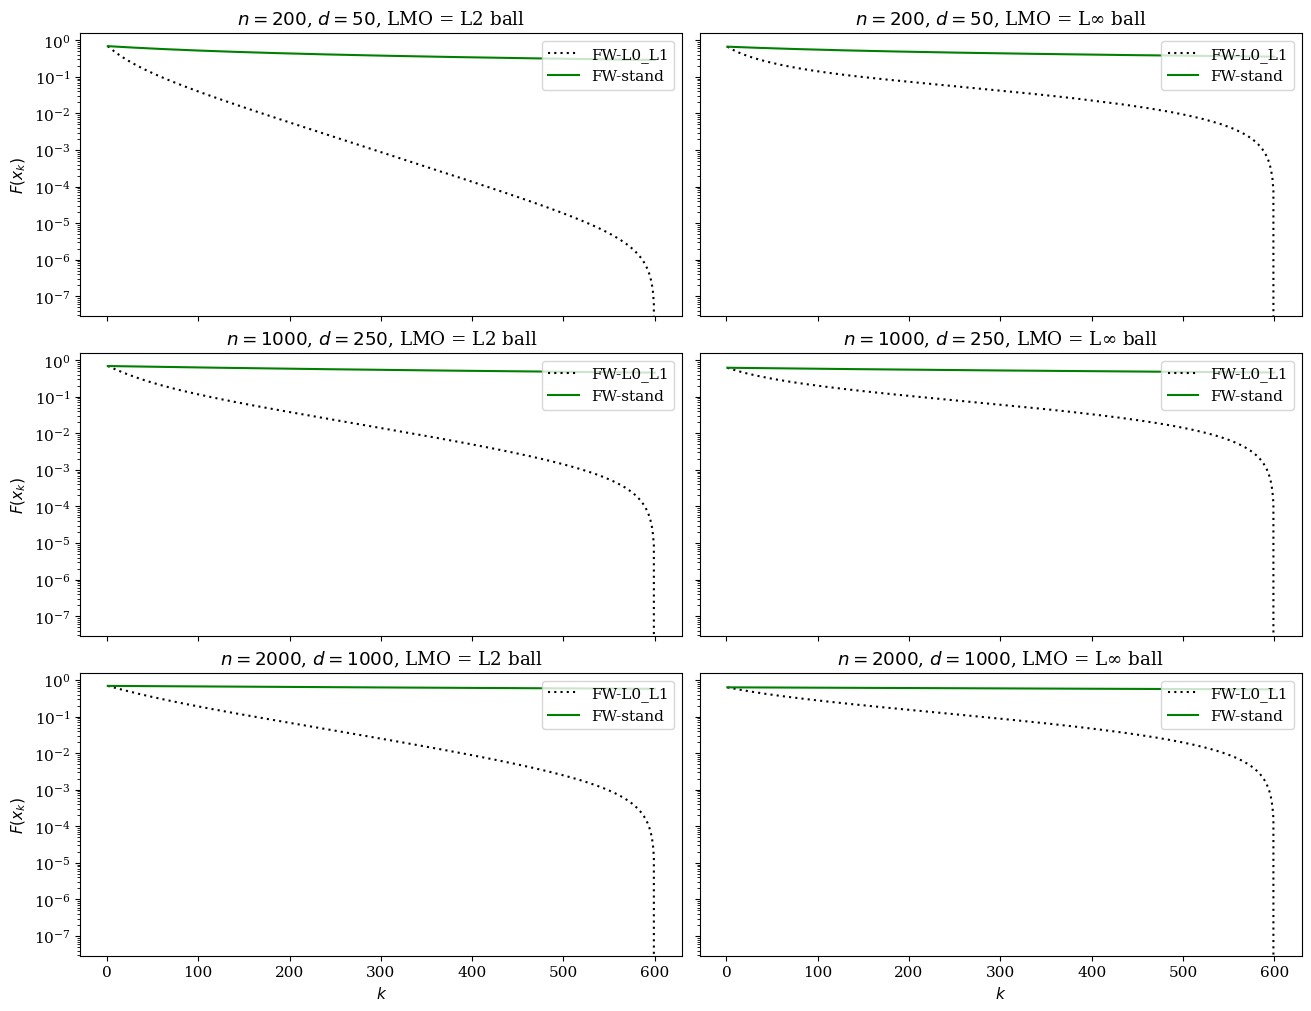

In [7]:
plt.rcParams.update({'font.size': 11, 'font.family': 'serif'})

fig, axes = plt.subplots(3, 2, figsize=(13, 10), sharex=True, sharey=True, constrained_layout=True)

eps = 1e-14
max_iters = 600
verbskip = max_iters / 10
ls_ratio = 2.2

l1_max_factor = 10

# parameters which ill be variated
ball_constrnt_radius = 250
n_samples, n_features = 1000, 25

# solution_spread_radius_btm = 0.95
# solution_spread_radius_up = 0.99


labels = [r"FW-L0_L1", r"FW-stand"]

configs = [
    (200, 50),
    (1000, 250),
    (2000, 1000),
]

lmo_names = ["L2 ball", "L∞ ball"]

for i, (n_samples, n_features) in enumerate(configs):
    np.random.seed(2025 + i)

    f, h, L, L0, L1, x0 = accbpg.L0L1_FW_log_reg(n_samples, n_features, ball_constrnt_radius)

    for j, (lmo, lmo_name) in enumerate(zip(
        [accbpg.lmo_l2_ball(ball_constrnt_radius), accbpg.lmo_linf_ball(ball_constrnt_radius)], lmo_names
    )):
        # Run FW-L0_L1
        _, F_l0l1, _, _, _ = accbpg.FW_alg_l0_l1_step_adapt(
            f, h, L0, L1, x0, max_iters, lmo, ls_ratio,
            epsilon=eps, linesearch=False, verbskip=verbskip
        )

        # Run FW-stand
        _, F_standard, _, _ = accbpg.FW_alg_div_step(
            f, h, L, x0, maxitrs=max_iters, gamma=2.0, lmo=lmo,
            epsilon=eps, linesearch=False, verbskip=verbskip
        )

        ax = axes[i, j]
        accbpg.plot_comparisons(
            ax,
            [F_l0l1, F_standard],
            labels,
            x_vals=[], plotdiff=True, yscale="log",
            xlabel=r"$k$" if i == 2 else "",
            ylabel=r"$F(x_k)$" if j == 0 else "",
            legendloc="upper right"
        )

        # Set informative title
        ax.set_title(f"$n = {n_samples}$, $d = {n_features}$, LMO = {lmo_name}")

# Optional: save the figure
# plt.savefig("FW_comparison_grid.pdf", bbox_inches='tight')
plt.show()


## Лог функция, адаптивные параметры. Эксперимент на датасете a9a Platt (1998)

Checking path: d:\projects\accbpg_and_fw\L0_L1_smoothness\datasets\a9a

FW L0,L1 smooth algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    1.299e+00    1.098e+02    5.000e-10    9.040e+01        1         0.5
    60    5.263e-01    2.964e-01    2.000e-09    3.616e+02       61         1.2
   120    5.263e-01    6.084e-01    2.684e-01    4.520e+02      121         1.8
   180    5.263e-01    2.830e-01    1.342e-01    2.260e+02      181         2.4
   240    5.263e-01    2.718e-01    1.342e-01    1.130e+02      241         2.9
   300    5.263e-01    5.405e-01    2.684e-01    2.260e+02      301         3.5
   360    5.263e-01    5.387e-01    2.684e-01    2.260e+02      361         4.1
   420    5.263e-01    5.379e-01    2.684e-01    2.260e+02      421         4.6
   480    5.263e-01    2.687e-01    1.342e-01    1.130e+02      481         5.2
   540    5.263e-01    2.685e-01    1.342e-01    1.130e+02      541         5.8

FW adaptive algorithm


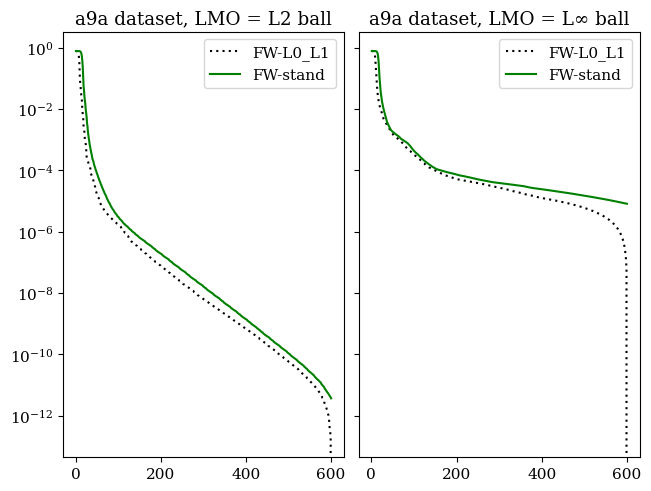

In [7]:
plt.rcParams.update({'font.size': 11, 'font.family': 'serif'})

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, constrained_layout=True)

eps = 1e-14
radius = 250
max_iters = 600
verbskip = max_iters / 10
ls_ratio = 2.0

l1_max_factor = 5

gamma = 2.0
labels = [r"FW-L0_L1", r"FW-stand"]

base_path = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))  # from ipynb to parameters_free_fw/
path = os.path.join(base_path, "L0_L1_smoothness", "datasets", "a9a")
print(f"Checking path: {path}")

f, h, L, L0, L1, x0 = accbpg.L0L1_FW_log_reg_a9a(radius, path)

for i, (lmo, lmo_name) in enumerate(zip(
    [accbpg.lmo_l2_ball(radius), accbpg.lmo_linf_ball(radius)], ["L2 ball", "L∞ ball"]
)):
    # Run FW-L0_L1
    _, F_l0l1, _, _, _ = accbpg.FW_alg_l0_l1_step_adapt(
        f, h, L0, L1, x0, max_iters, lmo, ls_ratio=ls_ratio, L1_max=L1 * l1_max_factor,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    # Run FW-stand
    _, F_standard, _, _ = accbpg.FW_alg_div_step(
        f, h, L, x0, maxitrs=max_iters, gamma=gamma, lmo=lmo,
        epsilon=eps, linesearch=True, verbskip=verbskip
    )

    ax = axes[i]
    accbpg.plot_comparisons(
        ax,
        [F_l0l1, F_standard],
        labels,
        x_vals=[], plotdiff=True, yscale="log",
        xlabel=r"$k$" if i == 2 else "",
        ylabel=r"$F(x_k)$" if j == 0 else "",
        legendloc="upper right"
    )

    # Set informative title
    ax.set_title(f"a9a dataset, LMO = {lmo_name}")

# Optional: save the figure
# plt.savefig("FW_comparison_grid.pdf", bbox_inches='tight')
plt.show()


## Влияние параметров L1,L0 на сходимость алгоритма

### Меняем параметр L1

radius is  250
true omega radius is  237.51708003385758
ratio positive labels: 0.523

FW L0,L1 smooth algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    1.478e+00    4.545e-10    1.716e+00        1         0.1
    60    3.290e-02    1.820e-02    1.000e-09    3.775e+00       61         0.1
   120    2.360e-02    1.449e-02    2.200e-09    8.306e+00      121         0.2
   180    1.806e-02    7.468e-03    1.000e-09    3.775e+00      181         0.2
   240    1.479e-02    5.247e-03    1.000e-09    3.775e+00      241         0.2
   300    1.297e-02    1.033e-02    4.840e-09    1.827e+01      301         0.3
   360    1.199e-02    9.856e-03    4.840e-09    1.827e+01      361         0.3
   420    1.120e-02    9.569e-03    4.840e-09    1.827e+01      421         0.3
   480    1.036e-02    7.952e-03    4.840e-09    1.827e+01      481         0.4
   540    9.631e-03    2.685e-03    1.000e-09    3.775e+00      541         0.4

FW L0,L1

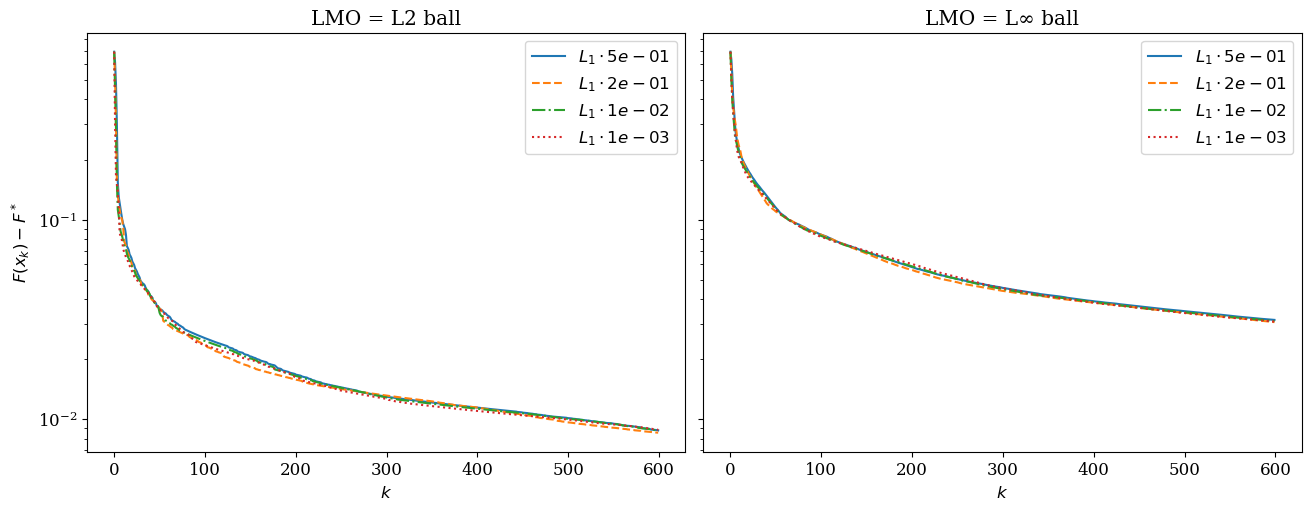

In [8]:
plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})

# Fixed setup
n_samples, n_features = 1000, 25
ball_constrnt_radius = 250
solution_spread_radius_btm = 0.95
solution_spread_radius_up = 0.99

eps = 1e-14
max_iters = 600
verbskip = max_iters / 10
ls_ratio = 2.2
l1_factors = [1/2, 1/5, 1/100, 1/1000]
lmo_names = ["L2 ball", "L∞ ball"]

# Create plots: 1 row, 2 columns for L2 and L∞
fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharey=True, constrained_layout=True)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
linestyles = ['-', '--', '-.', ':']

# Prepare problem once
# np.random.seed(2025)
f, h, L, L0, L1_orig, x0 = accbpg.L0L1_FW_log_reg(
    n_samples, n_features, ball_constrnt_radius,
    solution_spread_radius_btm=solution_spread_radius_btm,
    solution_spread_radius_up=solution_spread_radius_up
)

# Loop over LMO types
for j, (lmo, lmo_name) in enumerate(zip(
    [accbpg.lmo_l2_ball(ball_constrnt_radius), accbpg.lmo_linf_ball(ball_constrnt_radius)],
    lmo_names
)):
    ax = axes[j]
    for k, factor in enumerate(l1_factors):
        L1_mod = L1_orig * factor
        _, F_vals, _, _, _ = accbpg.FW_alg_l0_l1_step_adapt(
            f, h, L0, L1_mod, x0, max_iters, lmo, ls_ratio,
            epsilon=eps, linesearch=True, verbskip=verbskip
        )
        ax.plot(F_vals, label=fr"$L_1 \cdot {factor:.0e}$", 
                linestyle=linestyles[k], color=colors[k])

    ax.set_yscale("log")
    ax.set_title(f"LMO = {lmo_name}")
    ax.set_xlabel(r"$k$")
    if j == 0:
        ax.set_ylabel(r"$F(x_k) - F^*$")
    ax.legend()

# Optional: save to file
# plt.savefig("FW_L1_variation_single_plot.pdf", bbox_inches="tight")
plt.show()


### Меняем параметр L0

radius is  250
true omega radius is  245.52049690301612
ratio positive labels: 0.515

FW L0,L1 smooth algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    2.979e+00    2.273e-10    3.408e+00        1         0.1
    60    3.869e-02    2.615e-02    5.000e-10    7.497e+00       61         0.2
   120    2.861e-02    1.275e-02    2.273e-10    3.408e+00      121         0.2
   180    2.201e-02    1.468e-02    5.000e-10    7.497e+00      181         0.3
   240    1.853e-02    1.588e-02    1.100e-09    1.649e+01      241         0.3
   300    1.651e-02    1.096e-02    1.100e-09    1.649e+01      301         0.4
   360    1.534e-02    1.066e-02    1.100e-09    1.649e+01      361         0.4
   420    1.430e-02    7.519e-03    5.000e-10    7.497e+00      421         0.4
   480    1.330e-02    2.880e-02    2.420e-09    3.629e+01      481         0.5
   540    1.192e-02    1.506e-02    1.100e-09    1.649e+01      541         0.5

FW L0,L1

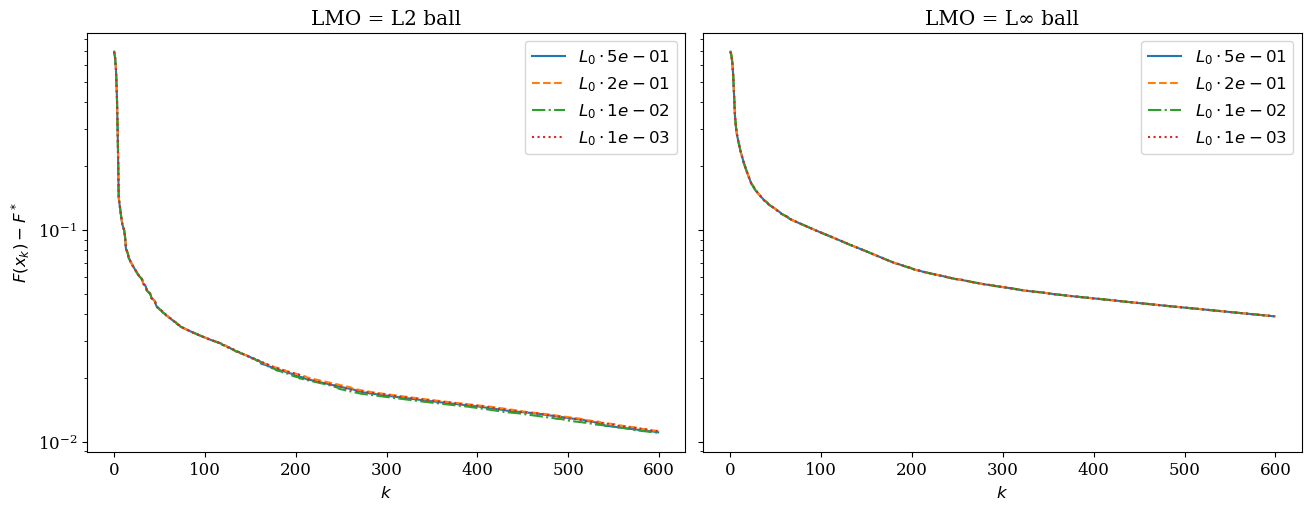

In [9]:
plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})

# Fixed problem settings
n_samples, n_features = 1000, 25
ball_constrnt_radius = 250
solution_spread_radius_btm = 0.95
solution_spread_radius_up = 0.99

eps = 1e-14
max_iters = 600
verbskip = max_iters / 10
ls_ratio = 2.2
l1_max_factor = None

l0_factors = [1/2, 1/5, 1/100, 1/1000]
lmo_names = ["L2 ball", "L∞ ball"]

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharey=True, constrained_layout=True)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
linestyles = ['-', '--', '-.', ':']

# Generate the problem only once
np.random.seed(2025)
f, h, L, L0_orig, L1, x0 = accbpg.L0L1_FW_log_reg(
    n_samples, n_features, ball_constrnt_radius,
    solution_spread_radius_btm=solution_spread_radius_btm,
    solution_spread_radius_up=solution_spread_radius_up
)

# Loop over LMO types
for j, (lmo, lmo_name) in enumerate(zip(
    [accbpg.lmo_l2_ball(ball_constrnt_radius), accbpg.lmo_linf_ball(ball_constrnt_radius)],
    lmo_names
)):
    ax = axes[j]
    for k, factor in enumerate(l0_factors):
        L0_mod = L0_orig * factor
        _, F_vals, _, _, _ = accbpg.FW_alg_l0_l1_step_adapt(
            f, h, L0_mod, L1, x0, max_iters, lmo, ls_ratio,
            epsilon=eps, linesearch=True, verbskip=verbskip
        )
        ax.plot(F_vals, label=fr"$L_0 \cdot {factor:.0e}$",
                linestyle=linestyles[k], color=colors[k])

    ax.set_yscale("log")
    ax.set_title(f"LMO = {lmo_name}")
    ax.set_xlabel(r"$k$")
    if j == 0:
        ax.set_ylabel(r"$F(x_k) - F^*$")
    ax.legend()

# Optional: save the figure
# plt.savefig("FW_L0_variation_single_plot.pdf", bbox_inches="tight")
plt.show()


### L1 и L0 уменьшаются одновременно

radius is  250
true omega radius is  245.84417613890724
ratio positive labels: 0.487

FW L0,L1 smooth algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    1.528e+00    2.273e-10    1.688e+00        1         0.1
    60    2.552e-02    2.716e-03    1.033e-10    7.672e-01       61         0.1
   120    1.900e-02    1.805e-02    1.100e-09    8.169e+00      121         0.2
   180    1.489e-02    2.565e-03    2.273e-10    1.688e+00      181         0.2
   240    1.263e-02    1.355e-02    2.420e-09    1.797e+01      241         0.2
   300    1.097e-02    8.846e-03    2.420e-09    1.797e+01      301         0.3
   360    1.009e-02    8.507e-03    2.420e-09    1.797e+01      361         0.3
   420    9.366e-03    8.237e-03    2.420e-09    1.797e+01      421         0.3
   480    8.671e-03    7.433e-03    2.420e-09    1.797e+01      481         0.4
   540    8.098e-03    1.184e-02    2.420e-09    1.797e+01      541         0.4

FW L0,L1

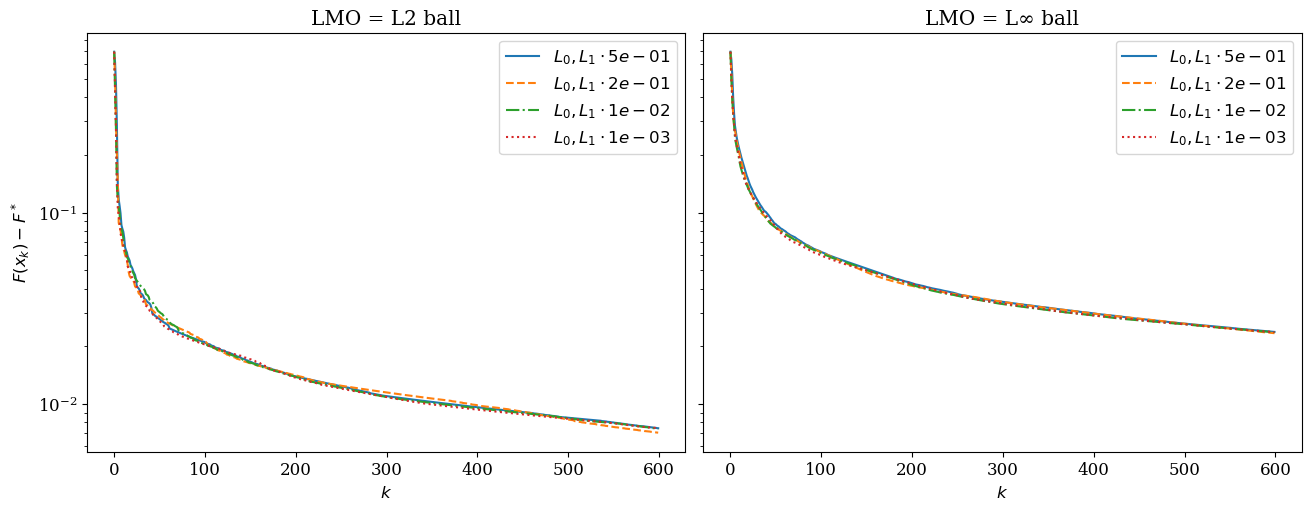

In [10]:
plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})

# Fixed problem settings
n_samples, n_features = 1000, 25
ball_constrnt_radius = 250
solution_spread_radius_btm = 0.95
solution_spread_radius_up = 0.99

eps = 1e-14
max_iters = 600
verbskip = max_iters / 10
ls_ratio = 2.2

l1_max_factor = None

# Scaling factors for both L0 and L1
scaling_factors = [1/2, 1/5, 1/100, 1/1000]
lmo_names = ["L2 ball", "L∞ ball"]

# Plot setup
fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharey=True, constrained_layout=True)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
linestyles = ['-', '--', '-.', ':']

# Prepare problem
# np.random.seed(2025)
f, h, L, L0_orig, L1_orig, x0 = accbpg.L0L1_FW_log_reg(
    n_samples, n_features, ball_constrnt_radius,
    solution_spread_radius_btm=solution_spread_radius_btm,
    solution_spread_radius_up=solution_spread_radius_up
)

# Loop over LMO types
for j, (lmo, lmo_name) in enumerate(zip(
    [accbpg.lmo_l2_ball(ball_constrnt_radius), accbpg.lmo_linf_ball(ball_constrnt_radius)],
    lmo_names
)):
    ax = axes[j]
    for k, factor in enumerate(scaling_factors):
        L0_mod = L0_orig * factor
        L1_mod = L1_orig * factor
        _, F_vals, _, _, _ = accbpg.FW_alg_l0_l1_step_adapt(
            f, h, L0_mod, L1_mod, x0, max_iters, lmo, ls_ratio,
            epsilon=eps, linesearch=True, verbskip=verbskip
        )
        ax.plot(F_vals, label=fr"$L_0, L_1 \cdot {factor:.0e}$",
                linestyle=linestyles[k], color=colors[k])

    ax.set_yscale("log")
    ax.set_title(f"LMO = {lmo_name}")
    ax.set_xlabel(r"$k$")
    if j == 0:
        ax.set_ylabel(r"$F(x_k) - F^*$")
    ax.legend()

# Optional: save
# plt.savefig("FW_L0_L1_joint_variation.pdf", bbox_inches="tight")
plt.show()

## Что даст ограничение $L_1$ сверху?

radius is  250
true omega radius is  238.47060668497755
ratio positive labels: 0.49

FW L0,L1 smooth algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    4.386e+00    4.545e-10    4.029e+00        1         0.1
   200    3.708e-06    8.793e-06    4.545e-10    4.029e+00      201         0.2
   400    3.337e-09    1.018e-08    1.000e-09    8.865e+00      401         0.3

FW L0,L1 smooth algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    4.386e+00    4.545e-10    4.029e+00        1         0.0
   200    3.708e-06    8.793e-06    4.545e-10    4.029e+00      201         0.1
   400    3.337e-09    1.018e-08    1.000e-09    8.865e+00      401         0.2

FW L0,L1 smooth algorithm
     k      F(x)         L         L0         L1     log step count       time
     0    6.931e-01    4.386e+00    4.545e-10    4.029e+00        1         0.0
   200    3.708e-06    8.793e-06    4.

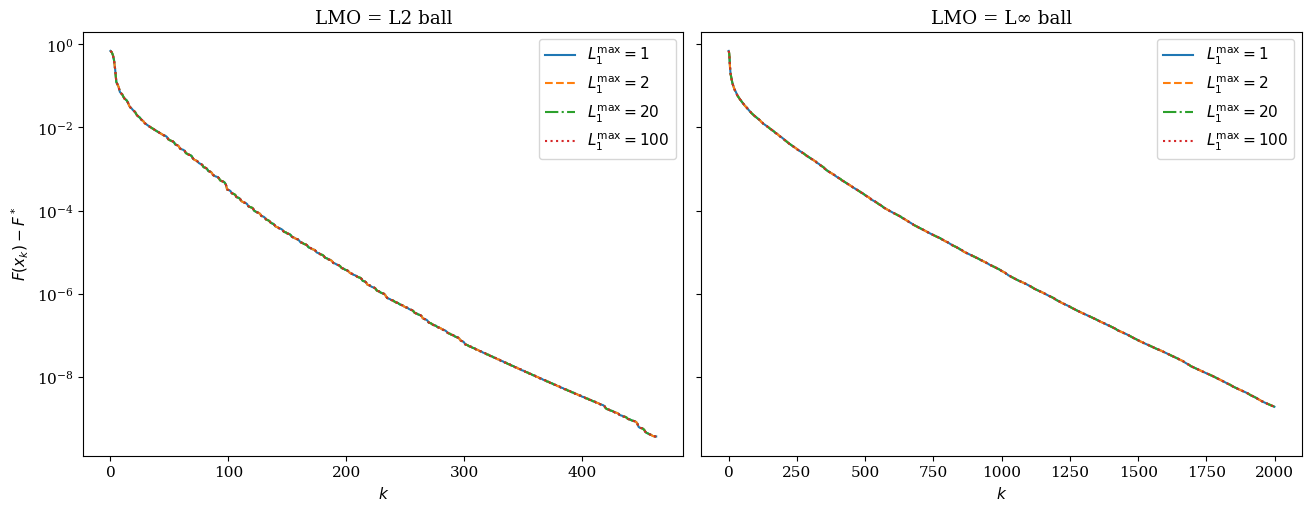

In [11]:
plt.rcParams.update({'font.size': 11, 'font.family': 'serif'})

# Problem settings
n_samples, n_features = 200, 50
ball_constrnt_radius = 250
solution_spread_radius_btm = 0.95
solution_spread_radius_up = 0.99

eps = 1e-14
max_iters = 2000
verbskip = max_iters / 10
ls_ratio = 2.2

# Factors to scale L1_max
l1_max_factors = [1, 2, 20, 100]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
linestyles = ['-', '--', '-.', ':']

lmo_names = ["L2 ball", "L∞ ball"]

# Setup figure
fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharey=True, constrained_layout=True)

# Create fixed problem instance
np.random.seed(2025)
f, h, L, L0, L1, x0 = accbpg.L0L1_FW_log_reg(
    n_samples, n_features, ball_constrnt_radius,
    solution_spread_radius_btm=solution_spread_radius_btm,
    solution_spread_radius_up=solution_spread_radius_up
)

# Loop over both LMOs
for j, (lmo, lmo_name) in enumerate(zip(
    [accbpg.lmo_l2_ball(ball_constrnt_radius), accbpg.lmo_linf_ball(ball_constrnt_radius)],
    lmo_names
)):
    ax = axes[j]
    for idx, factor in enumerate(l1_max_factors):
        _, F_l0l1, _, _, _ = accbpg.FW_alg_l0_l1_step_adapt(
            f, h, L0, L1, x0, max_iters, lmo, ls_ratio,
            L1_max=L1*factor, epsilon=eps, linesearch=True, verbskip=verbskip
        )
        ax.plot(F_l0l1, label=fr"$L_1^{{\max}} = {factor}$",
                linestyle=linestyles[idx], color=colors[idx])

    ax.set_yscale("log")
    ax.set_title(f"LMO = {lmo_name}")
    ax.set_xlabel(r"$k$")
    if j == 0:
        ax.set_ylabel(r"$F(x_k) - F^*$")
    ax.legend()

# Save or show
# plt.savefig("FW_L1max_variation.pdf", bbox_inches="tight")
plt.show()


## Выводы 21.07.25

Когда я поставил условие адаптивности из нашей статье, то почти все предыдущие выводбы обнулились, а именно:
- Улучшение сходимости, когда мы меняем $L_1$ на старте исчезло. Сейчас отличий почти нет
- Ухудшение сходимости при занижении $L_1^\text{max}$ исчезло. Сейчас отличий почти нет
- Во всех алгоритмах со случайной генерацией алгоритм ничем не отличается от классической версии, а на политопах отстает. Что наталкивает на мысль, что новый алгоритм не лучше старого.


После неудачной попытки в неравенство адаптивности поставить лемму спуска, я поставил условие адаптивности в том виде, в котором оно было до подставноки шага, т.е. это полный аналог неравенства, которым мы пользовались, нпрмр, в относительной гладкости.:
$$
f(y) \leq f(x) + \nabla f(x)^\top (y - x) + \frac{L_0 + L_1 \| \nabla f(x) \|}{L_1^2} \left( \exp\left(L_1 \| y - x \|\right) - L_1 \| y - x \| - 1 \right)
$$

Считаю, что именно это условие и должно быть, т.к. теоретический вывод алгоритма опирался именно на это неравенство, а не на то, которое было до этого.

## Выводы 20.07.25


1. По рекоммендации научного руководителя попробовал в неравенство адаптивности я добавил неравенство спуска прямиком из нашего доказательства:

```Python
is_descent_satisfied = True
if L1 * d_norm >= np.log(2):
    with np.errstate(over='raise', invalid='raise', divide='raise'):
        try:
            is_descent_satisfied = (fx - fx1) >= (grad_d_prod**2 / (L1 * grad_d_prod + 2 * a_k * d_norm) - 1e-5)
        except FloatingPointError as e:
            print("Caught overflow:", e)
            raise

else:
    q = min(1.5, L1 * d_norm)
    is_descent_satisfied = (fx - fx1) >= ((q - 2/3 * q**2) * grad_d_prod**2 / (2 * a_k * d_norm))

...

if is_descent_satisfied:
    break
else:
    ...
```
По итогу данное неравенство, если не вычитать - 1e-5, очень-очень медленно убывает, поэтому L0 и L1 становятся выше, чем `10e+309` и возникает переполнение (именно для этого в этом коде и сделан try catch). Возможно, это потому что в правой части неравенства у нас дробь и переменная в знаменателе, а такая функция очень медленно убывает. Что стало после того как вычел 1e-5? Результирующая сумма $L_0 + L_1 \| \nabla f(x_k) \|$ все еще огромна и метод вообще почти не сходится. По итогу не совсем вижу смысл пихать это неравенство. Изначально научному руководителю не понравилось, что текущее неравенство учитывает выпуклость, но у нас ведь и так выпуклая функция, поэтому не вижу смысла его менять.

2) Так же добавил ограничение сверху на оба параметра $L_1,L_0$, это было сделано для того, чтобы $L1$ сильно не менялся, если $L_0$ не может долго адаптироваться. Но какие значния $L_1^{\text{max}}$ и $L_0^{\text{max}}$ должны быть поставлены? Логично, что верхняя граница должна быть установлена в реальные значения $L_1, L_0$, если они известны, конечно. Я в итоге поставил реальное значение и домножил его для запаса: `l1_max_factor = 5`. Это не повлияло на сходимость, но это и не ожидалось поэтому все хорошо. 

Однако я все равно провел эксперимент и попереключал разные $L_1^{\text{max}}$, в итоге эксперимен показал, что если устанавливать $L_1^{\text{max}} = L_1 \cdot 1$ или $L_1^{\text{max}} = L_1 \cdot 2$, то сходимость сильно ухудшится на сильно выпуклом множестве. Кстати, в этих случаях шаг переключаться в НЕлогарифмический шаг, может это связано как-то с этим.

Переключение $L_0^{\text{max}} = L_0$ вообще ничего не дало.

## Выводы

1)  FW-L0_L1 четко быстрее при фиксированных реальных параметрах $L0, L1, L$ на любом множестве. 
2) Адаптивный FW-L0_L1 опережает только на l2 шаре и только на радиусах допустимого множества начиная примерно со 100 по евклидовой норме, остальные параметры на сходимость не влияют: удаленность начальной точки от решения, параметры самой целевой функции
3) В экспериментах было убедительно показано, что уменьшение начального значения параметра $L_1$ существенно ускоряет алгоритм на политопе. На сильно выпуклом же множестве ситуация почти не меняется. Изменение параметра $L_0$ ситуацию никак не меняет. Это так же свидетельствует о том, что дело не в соотношении между параметрами, а именно в величине параметра $L_1$. Я подумал, что может это птмчто параметр $L_0$ перед началом итерации и так околонулевой, тогда я попробовал этот параметр не уменьшать, а увеличивать и это так же никак не изменило график сходимости. Такое положение дел соответствует нашим теоретическим оценкам, т.к. у нас оценка такая $f(x_k) - f^* \leq \frac{\text{max} \{ 6L_0 D, 5 L_1 M D\}}{k+3}$, где $M$ - максимальное значение нормы градиента.

Важные примечания:
- Я пробовал адаптивность расчитывать по гессиану: $\| \nabla^2 f(x)\| \leq L_0 + L_1 \| \nabla f(x)\|$, но расчеты шли намного-намного дольше + сходимость почему-то сильно ухудшились. Однако, такое условие не подойдет так же и по идейным соображениям, т.к. нам нужно соответствие по 2-м точкам, а именно наш алгоритм работает на двух точках $x_{k+1}, x_k$, тут же мы ориентируемся только на одну. Т.е. так делать не надо.
- Я пробовал так же делать другие условия адаптивности по формулам из "Optimizing (L0, L1)-Smooth Functions by Gradient Methods
Daniil Vankov∗ Anton Rodomanov† Angelia Nedich‡ Lalitha Sankar", но ничего не менялось
- Сначала $L_2$ сильно осциллировл, затем я убрал регуляризацию и FW-L0_L1 нормализовался
- Почти всегда и везде выполнялся логарифмический шаг, т.е. всегда выполнялось условие $L_1 \| d_k \| \geq \text{ln}2$. ОДнако были экспреименты, где выполнялся и второй вид шага, но там на сходимость это шибко не влияло (в этих экспериментах этого нет)
- Пчму-то если матрица $A$ умножать на скаляр, то FW-L0_L1 начинает работать очень плохо